In [1]:
pip install git+https://github.com/pfnet-research/xfeat.git

  Cloning https://github.com/pfnet-research/xfeat.git to /tmp/pip-req-build-rpxm7oro
  Running command git clone -q https://github.com/pfnet-research/xfeat.git /tmp/pip-req-build-rpxm7oro
  ERROR: Error [Errno 2] No such file or directory: 'git': 'git' while executing command git clone -q https://github.com/pfnet-research/xfeat.git /tmp/pip-req-build-rpxm7oro
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install packaging

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [4]:
import re
from functools import partial
from glob import glob

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xfeat
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import (ArithmeticCombinations, ConcatCombination,
                   GBDTFeatureExplorer, GBDTFeatureSelector, LabelEncoder,
                   LambdaEncoder, Pipeline, SelectCategorical, SelectNumerical,
                   TargetEncoder, aggregation)
sns.set()

In [10]:
# データ前処理用関数を作成

def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori


def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area


def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki


# データ読み込み

paths = glob('/work/inputs/train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv('/work/inputs/test.csv')

sub_df = pd.read_csv('/work/inputs/sample_submission.csv')

ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

test_df[TARGET] = np.nan
df = pd.concat([train_df, test_df])

rm_cols += ['市区町村コード']

for i, v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)
df = pd.concat([train_df, test_df])

# 特徴量生成

enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

# Target Encoding
# ある行の特徴量として平均値を計算するのに、その時点で過去に登場したデータの集計を用いる
# 以下例では、都道府県ごとに各取引時点より過去の値の平均値を用いる
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()


def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0


df[group_col+'_te'] = df.apply(calc_te, axis=1)

df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2020-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

# 数値データを抽出しておく
num_df = SelectNumerical().fit_transform(df)

# カテゴリカルデータを抽出
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)



/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
# 数値データを組み合わせた特徴量生成
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"],
            drop_origin=True,
            operator="*",
            r=2,
        ),
    ]
)

num_comb_df = encoder.fit_transform(df)/100

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['今後の利用目的', '取引の事情等', '取引時点_enc', '地区名', '市区町村名', '建物の構造', '改装', '最寄駅：名称', '用途', '都市計画', '都道府県名', '間取り']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dat

Training until validation scores don't improve for 100 rounds
[100]	train's l1: 0.080357	valid's l1: 0.0957692
[200]	train's l1: 0.0760557	valid's l1: 0.0916893
[300]	train's l1: 0.0738259	valid's l1: 0.0898385
[400]	train's l1: 0.0725408	valid's l1: 0.089038
[500]	train's l1: 0.071435	valid's l1: 0.0884334
[600]	train's l1: 0.07063	valid's l1: 0.0879844
[700]	train's l1: 0.0699513	valid's l1: 0.0875694
[800]	train's l1: 0.069437	valid's l1: 0.0873661
[900]	train's l1: 0.0688698	valid's l1: 0.0869878
[1000]	train's l1: 0.0683464	valid's l1: 0.0867361
[1100]	train's l1: 0.0678439	valid's l1: 0.0866143
[1200]	train's l1: 0.0674652	valid's l1: 0.0865389
[1300]	train's l1: 0.0670885	valid's l1: 0.0864223
[1400]	train's l1: 0.0666769	valid's l1: 0.0862736
[1500]	train's l1: 0.0663199	valid's l1: 0.0861748
[1600]	train's l1: 0.0659877	valid's l1: 0.0861053
[1700]	train's l1: 0.0656531	valid's l1: 0.0860489
[1800]	train's l1: 0.0653542	valid's l1: 0.0860246
[1900]	train's l1: 0.0650344	valid'

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65285 missing from c

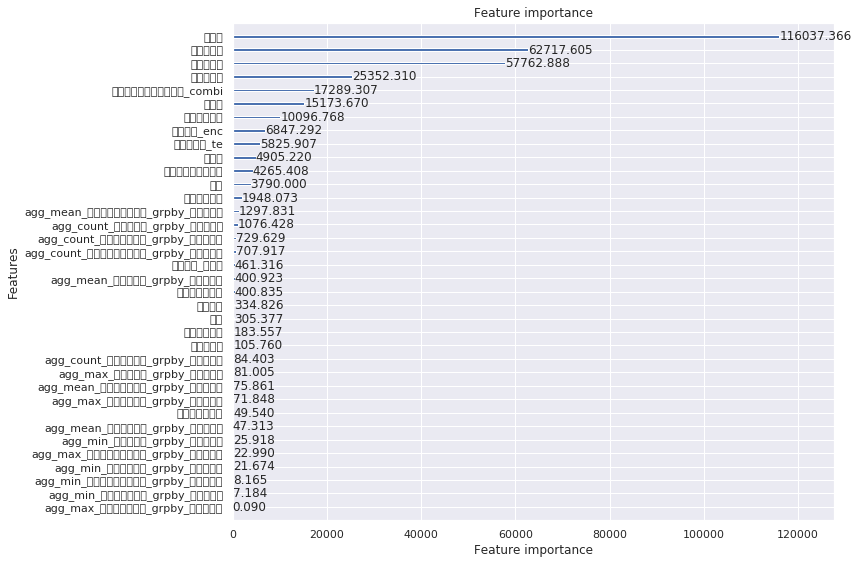

In [8]:
# 集約特徴量生成
agg_dfs = []


def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                                   group_key=group_col,
                                   # '前面道路：幅員（ｍ）',
                                   group_values=['最寄駅：距離（分）',
                                                 '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                                   agg_methods=['count', 'mean', 'min', 'max'],
                                   )

    return agg_df[agg_cols]


group_col = '市区町村名'
agg_dfs.append(get_agg_df(df, group_col))

# 生成した特徴量を結合
feat_df = pd.concat([num_df, le_df, num_comb_df]+agg_dfs, axis=1)

# モデル構築
train_df = feat_df[feat_df['取引時点_何年前'] > 1]
val_df = feat_df[feat_df['取引時点_何年前'] == 1]
test_df = feat_df[feat_df['取引時点_何年前'] == 0]

feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

cat_cols = list(le_df.columns) + ['取引時点_enc']

train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(val_x, label=val_y)

model = lgb.train(
    params,
    train_data,
    categorical_feature=cat_cols,
    valid_names=['train', 'valid'],
    valid_sets=[train_data, val_data],
    verbose_eval=100,
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=[
                       'index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(
), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')
# score: 0.0918

# 特徴量の重要度可視化
lgb.plot_importance(model, figsize=(
    12, 8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

test_pred = model.predict(test_x, num_iteration=model.best_iteration)

# 投稿ファイル作成
sub_df[TARGET] = test_pred
sub_df.to_csv('/work/outputs/ch_submission.csv', index=False)